In [15]:
import seaborn as sns
import os
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import numpy as np
from matplotlib.lines import Line2D
from pathlib import Path
from glob import glob

DATA_PATH = "../data"

def rreplace(s, old, new, occurrence):
    li = s.rsplit(old, occurrence)
    return new.join(li)


def create_resdf(sg_results):
    res_df = pd.DataFrame(columns=['r2_mean_val', 'r2_max_val', 'r2_min_val', 'mse_mean_val', 'mse_max_val', 'mse_min_val', 'r2_mean_train', 'r2_max_train', 'r2_min_train', 'mse_mean_train', 'mse_max_train', 'mse_min_train','S_mean', 'S_max', 'S_min'])

    for i, (lam, sg_res) in enumerate(sg_results.items()):
        r2_mean_val = np.mean(sg_res['r2_valid'])
        r2_max_val = r2_mean_val+1.96 * np.std(sg_res['r2_valid']) / np.sqrt(5)
        r2_min_val = r2_mean_val-1.96 * np.std(sg_res['r2_valid']) / np.sqrt(5)
        mse_mean_val = np.mean(sg_res['mse_valid'])
        mse_max_val = mse_mean_val+1.96 * np.std(sg_res['mse_valid']) / np.sqrt(5)
        mse_min_val = mse_mean_val-1.96 * np.std(sg_res['mse_valid']) / np.sqrt(5)
        
        r2_mean_train = np.mean(sg_res['r2_train'])
        r2_max_train = r2_mean_train+1.96 * np.std(sg_res['r2_train']) / np.sqrt(5)
        r2_min_train = r2_mean_train-1.96 * np.std(sg_res['r2_train']) / np.sqrt(5)
        mse_mean_train = np.mean(sg_res['mse_train'])
        mse_max_train = mse_mean_train+1.96 * np.std(sg_res['mse_train']) / np.sqrt(5)
        mse_min_train = mse_mean_train-1.96 * np.std(sg_res['mse_train']) / np.sqrt(5)
        S_mean = np.mean(sg_res['S'])
        S_max = S_mean+1.96 * np.std(sg_res['S']) / np.sqrt(5)
        S_min = S_mean-1.96 * np.std(sg_res['S']) / np.sqrt(5)
        res_df.loc[lam] = ([r2_mean_val, r2_max_val, r2_min_val, mse_mean_val, mse_max_val, mse_min_val, r2_mean_train, r2_max_train, r2_min_train, mse_mean_train, mse_max_train, mse_min_train, S_mean, S_max, S_min])
    return res_df

def plot_loss_vs_lambda(sg_results, ax, log=False):
    res_df = create_resdf(sg_results)
    colors = ['rgb(27,158,119)', 'rgb(217,95,2)', 'rgb(117,112,179)']
    colors = [s.replace('rgb', '') for s in colors]
    colors = [eval(s) for s in colors]
    colors = ['#1b9e77', '#d95f02', '#7570b3']
    res_df.index = res_df.index.astype('float')
    ncov = res_df.S_max.max()

    ax.plot(res_df.index, res_df['mse_mean_val'],
            c=colors[1], label='test loss (mean)')
    ax.plot(res_df.index, res_df['mse_mean_train'],
            c=colors[2], label='train loss (mean)')
    if log:
        ax.set_xscale('log')

    ax2 = ax.twinx()
    ax2.plot(res_df.index, res_df['S_mean'],
             c=colors[0], label='number of covariates (mean)')
    ax2.set_ylim(ymin=0)
    ax2.set_ylabel('number of covariates', c=colors[0])
    ax.set_ylabel('loss (MSE)')
    ax2.set_yticks(np.arange(0, ncov, 2))
    ax.set_xlabel('$\lambda$')
    ax.legend(loc=1)
    ax2.legend(loc=3)
    return ax


def plot_r2_vs_lambda(sg_results, ax):
    res_df = create_resdf(sg_results)
    colors = ['rgb(27,158,119)', 'rgb(217,95,2)', 'rgb(117,112,179)']
    colors = [s.replace('rgb', '') for s in colors]
    colors = [eval(s) for s in colors]
    colors = ['#1b9e77', '#d95f02', '#7570b3']
    res_df.index = res_df.index.astype('float')
    fig, ax = plt.subplots(figsize=(6, 4))
    ncov = res_df.S_max.max()

    ax.plot(res_df.index, res_df['r2_mean_val'],
            c=colors[1], label='test r2 (mean)')
    ax.plot(res_df.index, res_df['r2_mean_train'],
            c=colors[2], label='train r2 (mean)')
    ax2 = ax.twinx()
    ax2.plot(res_df.index, res_df['S_mean'],
             c=colors[0], label='number of covariates (mean)')
    ax2.set_ylim(ymin=0)
    ax2.set_ylabel('number of covariates', c=colors[0])
    ax.set_ylabel('R2 (MSE)')
    ax2.set_yticks(np.arange(0, ncov, 2))
    ax.set_xlabel('$\lambda$')
    ax.legend(loc=1)
    ax2.legend(loc=3)
    return ax


def plot_frequencies(sg_results, ax):
    newdic = {}
    for lam, x in sg_results.items():
        newdic[lam] = defaultdict(int)
        for fold in x['feat_importances']:
            for k, v in fold.items():
                newdic[lam][k] += int(v>0.5)  
    
    df = pd.DataFrame(newdic).T
    df.columns = [rreplace(char, '_', '=', 1).replace('.0', '')
                  for char in df.columns]
    cmap1 = plt.get_cmap('Reds', 6).copy()
    sns.heatmap(df, ax=ax, cbar_kws={'label': 'frequency of covariate', 'pad': 0.05,
                'aspect': 20}, vmin=-0.5, vmax=5.5, cmap=cmap1, linewidths=0.005, linecolor='black')
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0, 1, 2, 3, 4, 5])
    cbar.set_ticklabels(['0/5', '1/5', '2/5', '3/5', '4/5', '5/5'])
    ax.set_ylabel('$\lambda$')
    return 


def plot_mus(res, ax, color_dict=None):
    allmus = np.array(res['mus'])
    covnames = [rreplace(char, '_', '=', 1).replace('.0', '')
                for char in list(res['feat_import_raw'])]
    allmus_df = pd.DataFrame(data=allmus[:, :], columns=covnames)
    for col in allmus_df.columns:
        try:
            ax.plot(allmus_df[col], label=col, c=color_dict[col])
        except:
            if (np.any(allmus_df[col].values > 0.1)):
                ax.plot(allmus_df[col], label=col)
            else:
                ax.plot(allmus_df[col], c='gray')

    ax.set_ylabel('$\mu$ values')
    ax = ax.legend().axes
    handles, labels = ax.get_legend_handles_labels()
    handles.append(Line2D([0], [0], c='gray'))
    labels.append("Rest")
    handles.append(Line2D([0], [0], c='black', ls=':'))
    labels.append("threshold")
    xlim = ax.get_xlim()
    ax.plot(xlim, [0.5, 0.5], c='black', ls=':')
    ax.legend(handles=handles, labels=labels)
    ax.set_xlabel('Iterations')


def plot_losses(res, ax, ylim=None):
    colors = ['#d95f02', '#7570b3']
    ax.plot(np.array(res['train_mse_arr']),
            c=colors[1], label='train loss')
    ax.plot(np.array(res['valid_mse_arr']),
            c=colors[0], label='valid loss')
    ax.legend()
    ax.set_xlabel('iterations')
    ax.set_ylabel('loss (MSE)')
    if ylim is not None:
        ax.set_ylim(ylim)

In [16]:
def loop_over_runs(path):
    sg_results = {}
    for lam in sorted(os.listdir(path)):
        try:
            lam_ = float(lam)
        except:
            continue
        sg_results[lam_] = defaultdict(list)
        subfolder = os.path.join(path, lam)
        res_fnames = glob(os.path.join(subfolder, 'results*.json'))
        for res_fname in res_fnames:
            bname = os.path.basename(res_fname)
            fold =''.join(x for x in bname if x.isdigit())
            with open (res_fname) as f:
                res = json.load(f)
            for k, v in res.items():
                if isinstance(v, float):
                    sg_results[lam_][k].append(v)
            sg_results[lam_]['feat_importances'].append(
                res['feat_import_raw'])
                
    return  sg_results

Text(0.5, 1.0, 'b. Discovered covariates across $\\lambda$ values')

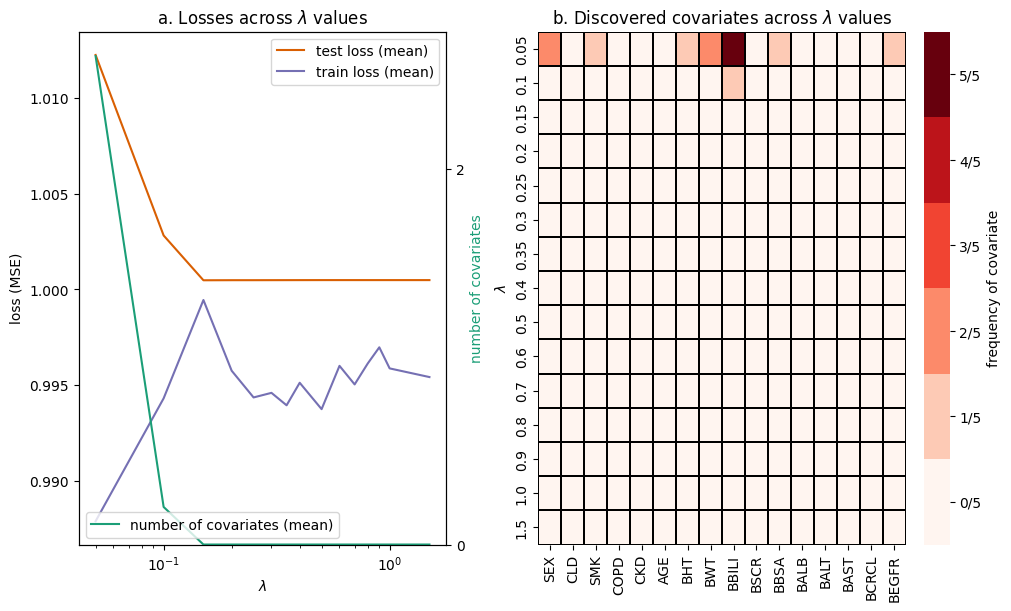

In [3]:
scenario = 'sparser_samp'

folder = f'{DATA_PATH}/{scenario}/output_CV/'

plt.close('all')
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 6))

sgresults = loop_over_runs(folder)
plot_loss_vs_lambda(sgresults, axs[0], log=True)
axs[0].set_title(f'a. Losses across $\lambda$ values')
plot_frequencies(sgresults, axs[1])
axs[1].set_title(f'b. Discovered covariates across $\lambda$ values')

In [14]:
sgresult.keys()

dict_keys(['r2_train', 'mse_train', 'r2_valid', 'mse_valid', 'S', 'feat_import_raw', 'good_fit', 'mus', 'train_mse_arr', 'valid_mse_arr', 'train_r2_arr', 'valid_r2_arr', 'shaps'])

Text(0.5, 1.0, 'b. Discovered covariates across $\\lambda$ values')

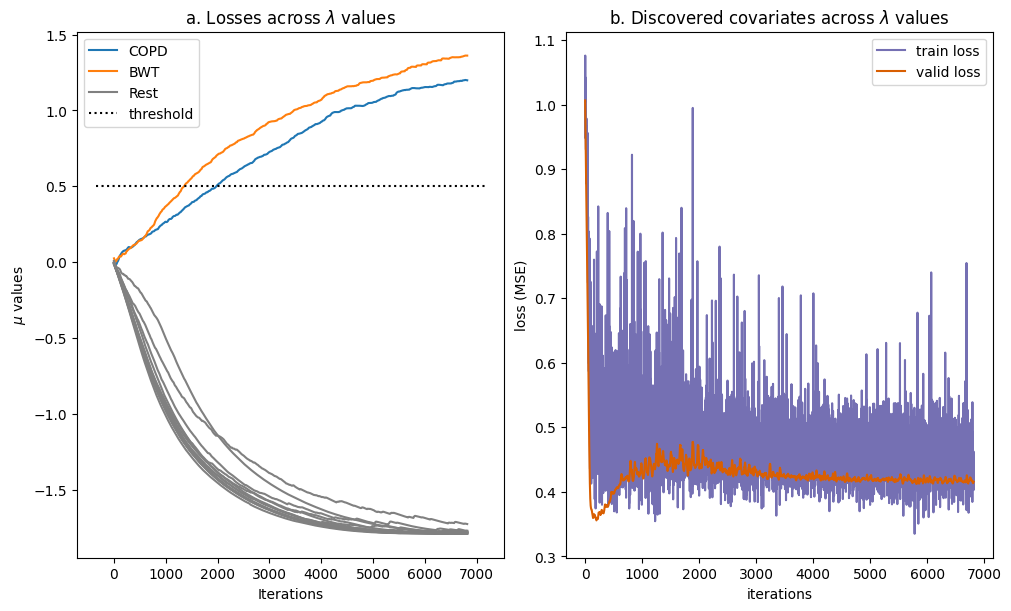

In [17]:
scenario = 'pop_100'

folder = f'{DATA_PATH}/{scenario}/output_train_test'
lam =1.0 
plt.close('all')
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 6))

with open (f'{folder}/{lam}/results.json') as f:
    sgresult = json.load(f)
    
plot_mus(sgresult, axs[0])
axs[0].set_title(f'a. Losses across $\lambda$ values')
plot_losses(sgresult, axs[1])
axs[1].set_title(f'b. Discovered covariates across $\lambda$ values')